In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import stats
import math
import random
from matplotlib import pyplot as plt 
import numpy as np  
import matplotlib.backends.backend_pdf
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sys
from pyecharts.charts import Bar
from pyecharts import options as opts
from pyecharts.globals import ThemeType
from pyecharts.charts import Bar
from pyecharts import options as opts
import dataframe_image as dfi
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
from IPython.core.display import display, HTML
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline
sns.set()

In [7]:
#Load the dataset with the calculated differences Y[t], ommit the first value because difference is NaN and print the head()

def file(fileinput):
    if not ".csv" in fileinput:
        fileinput = "data/" + fileinput + ".csv"
    
    global df
    df = pd.read_csv(fileinput,skiprows=0)
    df['difference'] = df.iloc[:,1].diff()
    df = df.iloc[1:]
    df.columns = ['date', 'X[t]', 'Y[t]']
    df.date = pd.to_datetime(df.date)
    df.set_index('date', inplace=True)
    return df


# Code for the Random(p) Problem

In [8]:
def random_prob_model(counter, probability):
    #From the dataframe these are the load values and the dates columns stored in arrays to be processed
    
    distribution = df.reset_index(drop=False).iloc[:,1].values
    distribution = distribution[:len(distribution)-31]
    dates = df.reset_index(drop=False).iloc[:,0].values

    #Fix a probability
    #probability = 0.5
    #counter = 100

    #Empty lists to store times we stopped, loads at each stop and the minimum values of each run and times
    load_list = []
    time_list = []
    minimums = []
    minimums_times = []
    
    
    load_data = []
    for i in range(0, len(distribution), counter):
        chunked_data = distribution[i:i + counter]
        min_value = min(chunked_data)
        minimums.append(min_value)
        min_index = np.where(chunked_data == min_value)[0][0]
        minimums_times.append(min_index)
        load_data.append(chunked_data)        

    for chunk in load_data:
        best = 0
        index = 0
        #Find the best candidate for the model to stop in the first run by comparing the random generated value with the fixed probability x
        #If less STOP and offload, else Keep looking unitl the 100th observation
        while index <= len(chunk)-1:
            x = random.uniform(0, 1)
            if x < probability:
                best = index
                #print ("Best candidate found! We offload on " + str(candidate_time[best]) + "\nThe load when we offload is " + str(candidate[best]))
                time_list.append(np.where(chunk == chunk[best])[0][0])
                load_list.append(chunk[best])
                #print("The difference between the Optimal and the Achieved load values is " + str(candidate[best] - minimumL))
                break
            elif index == counter-1:
                best = index
                #print ("Best candidate found! We offload on " + str(next_times[-1]) + "\nThe load when we offload is "  + str(next_observations[-1]))
                time_list.append(np.where(chunk == chunk[best])[0][0])
                load_list.append(chunk[best])
                #print("The difference between the Optimal and the Achieved load values is " + str(next_observations[-1] - minimumL))
                break
            index += 1
    
    load_differences = np.asarray(load_list) - np.asarray(minimums)
    times_differences = np.array(time_list) - np.array(minimums_times)
    
    return minimums, load_list, load_differences, minimums_times, time_list, times_differences



# Code for Secretary Model

In [9]:
def secretary_model(counter):
    #This is the code for the Secretary Problem

    #From the dataframe these are the load values and the dates columns stored in arrays to be processed
    distribution = df.reset_index(drop=False).iloc[:,1].values
    distribution = distribution[:len(distribution)-31]
    dates = df.reset_index(drop=False).iloc[:,0].values

    #Empty lists to store times we stopped, loads at each stop and the minimum values of each run
    time_list = []
    load_list = []
    minimums = []
    minimums_times = []
    
    load_data = []
    for i in range(0, len(distribution), counter):
        chunked_data = distribution[i:i + counter]
        min_value = min(chunked_data)
        minimums.append(min_value)
        min_index = np.where(chunked_data == min_value)[0][0]
        minimums_times.append(min_index)
        load_data.append(chunked_data)
    
    for chunk in load_data:
        samplesize = round(len(chunk) * math.exp(-1))
        sample = chunk[ : samplesize]

        #Compute the benchmark_secretary of the sample (minimum values of the sample)
        benchmark = min(sample)

        best = 0
        index = samplesize

        #Find the best_secretary candidate_secretary for the model to stop in the first run by comparing all next values with the benchmark_secretary value
        while index <= len(chunk)-1:
            if chunk[index] <= benchmark:
                best = index
                break
            index += 1

        #Once we observe the first that is less than the benchmark_secretary value STOP there and offload. Store the value
        if(chunk[best] <= benchmark):
            time_list.append(np.where(chunk == chunk[best])[0][0])
            load_list.append(chunk[best])

        #If we dont then go to the end of the 100 observations, Stop there and offload
        elif index == counter:
            best = index
            time_list.append(np.where(chunk == chunk[best-1])[0][0])
            load_list.append(chunk[best-1])

    load_differences = np.asarray(load_list) - np.asarray(minimums)
    times_differences = np.array(time_list) - np.array(minimums_times)
    time_delays = [x - 37 for x in time_list]
    
    return minimums, load_list, load_differences, minimums_times, time_list, times_differences


# Code for the House Selling Model

In [10]:
#Without Dataset
# A = [[2,6,7,10,4,7,4,8,9,3], [8,5,3,9,1,7,9,10,4,3]] 
def house_selling_model(counter, r):
    distribution = df.reset_index(drop=False).iloc[:,1].values
    distribution = distribution[:len(distribution)-31]
    dates = df.reset_index(drop=False).iloc[:,0].values

    N = counter

    #Empty lists to store times we stopped, loads at each stop and the minimum values of each run and times
    scaled_list = []
    load_list = []
    time_list = []
    minimums = []
    minimums_times = []

    A = []
    for i in range(0, len(distribution), counter):
        chunked_data = distribution[i:i + counter]
        min_value = min(chunked_data)
        minimums.append(min_value)
        min_index = np.where(chunked_data == min_value)[0][0]
        minimums_times.append(min_index)
        A.append(chunked_data)

    # Scale the availability values
    for each in A:
        scaled_availability = np.full(shape=len(each), fill_value=0, dtype=np.float)
        for k in range(1,len(each)):
            scaled_availability[k] = (max(each) - each[k])/(max(each) - min(each))
        scaled_list.append(scaled_availability)
        

    d = np.full(shape=counter, fill_value=0, dtype=np.float)
    for i in range(N-2,-1,-1):
        d[i] = (1/(1+r))*((1+(d[i+1])**2)/2)


    c = 0
    for each_list in scaled_list:
        for i in range(0,len(each_list)+1):
            if each_list[i] >= d[i]:
                load_list.append(A[c][i])
                time_list.append(i)
                break
        c += 1
        
    load_differences = np.asarray(load_list) - np.asarray(minimums)
    times_differences = np.array(time_list) - np.array(minimums_times)
    
    return minimums, load_list, load_differences, minimums_times, time_list, times_differences

In [11]:
# a = np.full(shape=10, fill_value=0, dtype=np.float)
# for i in range(10-2,-1,-1):
#     a[i] = (1/(1+0.5))*((1+(a[i+1])**2)/2)
    
# print(a)

# plt.plot(a)
# plt.xlabel("Number of Decision Values")
# plt.ylabel("Decision Value")
# plt.title("A line plot of the decision values for N availability values")

# RUNS AND VALUES SIMULATIONS FOR MODELS

In [17]:
#Simulate the random prob model by defining the rpb to be executed
#Define chunk_func as rpb_200[0-4] and chunks N
def randomP_simulation_run(chunk_func, N):
    n_groups = len(chunk_func[0])

    # create plot for loads
    plt.figure(figsize=(30,25))
    index = np.arange(n_groups)
    bar_width = 0.4
    opacity = 0.8

    #Loads Plot
    #Plot the achieved values of each observed samle
    rects2 = plt.bar(index, chunk_func[1], bar_width,alpha=opacity,color='black',label='Achieved')
    #Plot the minimum values of each observed sample
    rects1 = plt.bar(index + bar_width, chunk_func[0], bar_width,alpha=opacity,color='darkred',label='Optimal')

    #Label
    plt.xlabel('Stops', size = 30)
    plt.ylabel('Load Values', size = 30)
    plt.title('Loads in each Run with N = {} for Random(P) Model'.format(N), size = 40)
    plt.xticks(index + (bar_width/2), tuple(range(1,n_groups+1)))
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
    plt.xlim([0-bar_width/2,index.size])
    plt.plot()
    plt.legend(prop={'size': 25})
    plt.savefig('randomp_figures/random(p)_{}.png'.format(N))

    
    
    plt.figure(figsize=(30,25))
    #Times Plot
    rects2 = plt.bar(index, np.absolute(chunk_func[5]), bar_width,alpha=opacity,color='darkblue',label='Time instance difference from optimal')
    
    #Label
    plt.xlabel('Stops', size = 30)
    plt.ylabel('Time Instances', size = 30)
    plt.title('Times in each Run with N = {} for Random(P) Model'.format(N), size = 40)
    plt.xticks(index, tuple(range(1,n_groups+1)))
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
    plt.xlim([0-bar_width/2,index.size])
    plt.plot()  
    plt.legend(prop={'size': 25})

    plt.savefig('randomp_figures/random(p)_times_{}.png'.format(N))
    
    #Display the dataframe
    runs_data = {'Run':  list(range(1,len(chunk_func[0])+1)),'Optimal': chunk_func[0],'Load when Offloading': chunk_func[1],
                 'Load Difference': chunk_func[2],}

    runs_frame = pd.DataFrame(runs_data, columns = ['Run','Optimal','Load when Offloading', 'Load Difference'])
    runs_frame.index += 1

    display(runs_frame)
    
    runs_frame.to_csv('randomp_figures/dataframes/randomp_data_{}.csv'.format(N))


#Simulate the random prob model by defining the rpb to be executed
#Define secretary_model as 200
def secretary_simulation_run(chunks):
    # data to plot
    n_groups_secretary = len(secretary_model(chunks)[0])

    # create plot for loads
    plt.figure(figsize=(30,25))
    index = np.arange(n_groups_secretary)
    bar_width = 0.4
    opacity = 0.8
    
    # Loads Plot
    #Plot the achieved values of each observed samle
    rects2 = plt.bar(index, secretary_model(chunks)[1], bar_width,alpha=opacity,color='black',label='Achieved')
    
    #Plot the minimum values of each observed sample
    rects1 = plt.bar(index + bar_width, secretary_model(chunks)[0], bar_width, alpha=opacity,color='darkred',label='Optimal')
    
    #Label
    plt.xlabel('Stops', size = 30)
    plt.ylabel('Load Values', size = 30)
    plt.title('Loads in each Run with N = {} for Secretary Model'.format(chunks), size = 40)
    plt.xticks(index + (bar_width/2), tuple(range(1,n_groups_secretary+1)))
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
    plt.xlim([0-bar_width/2,index.size])
    plt.plot()
    plt.legend(prop={'size': 25})
    plt.savefig('secretary_figures/secretary_{}.png'.format(chunks))



    #Time Plot
    plt.figure(figsize=(30,25))

    #Plot the minimum values of each observed sample
    rects1 = plt.bar(index + bar_width, secretary_model(chunks)[5], bar_width, alpha=opacity,color='darkblue',label='Time instance difference from optimal')
    
    #Label
    plt.xlabel('Stops', size = 30)
    plt.ylabel('Time Instances', size = 30)
    plt.title('Times in each Run with N = {} for Secretary Model'.format(chunks), size = 40)
    plt.xticks(index + (bar_width), tuple(range(1,n_groups_secretary+1)))
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
    plt.xlim([0-bar_width/2,index.size])
    plt.plot()
    plt.legend(prop={'size': 25})

    
#    ax2.plot()
    plt.savefig('secretary_figures/secretary_times_{}.png'.format(chunks))
    
    
    #Display the dataframe
    runs_data = {'Run':  list(range(1,len(secretary_model(chunks)[0])+1)),'Optimal': secretary_model(chunks)[0],'Load when Offloading': secretary_model(chunks)[1],
                 'Load Difference': secretary_model(chunks)[2],}

    runs_frame = pd.DataFrame(runs_data, columns = ['Run','Optimal','Load when Offloading', 'Load Difference'])
    runs_frame.index += 1

    display(runs_frame)
    
    runs_frame.to_csv('secretary_figures/dataframes/secretary_data_{}.csv'.format(chunks))

def house_selling_simulation_run(chunks, r):
    n_groups_house = len(house_selling_model(chunks, r)[0])

    # create plot for loads
    plt.figure(figsize=(30,25))
    index = np.arange(n_groups_house)
    bar_width = 0.4
    opacity = 0.8
    
    # Loads Plot
    #Plot the achieved values of each observed samle
    rects2 = plt.bar(index, house_selling_model(chunks, r)[1], bar_width,alpha=opacity,color='black',label='Achieved')
    #Plot the minimum values of each observed sample
    rects1 = plt.bar(index + bar_width, house_selling_model(chunks, r)[0], bar_width, alpha=opacity,color='darkred',label='Optimal')
    
    #Label
    #Label
    plt.xlabel('Stops', size = 30)
    plt.ylabel('Load Values', size = 30)
    plt.title('Loads in each Run with N = {} for House Selling Model'.format(chunks), size = 40)
    plt.xticks(index + (bar_width/2), tuple(range(1,n_groups_house+1)))
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
    plt.xlim([0-bar_width/2,index.size])
    plt.legend(prop={'size': 25})
    plt.savefig('house_selling_figures/hs_{}.png'.format(chunks))
    
    plt.figure(figsize=(30,25))
    # Times Plot
    #Plot the achieved values of each observed sample
    rects2 = plt.bar(index, house_selling_model(chunks, r)[5], bar_width,alpha=opacity,color='darkblue',label='Time instance difference from optimal')
    
    plt.xlabel('Stops', size = 30)
    plt.ylabel('Time Instances', size = 30)
    plt.title('Times in each Run with N = {} for House Selling Model'.format(chunks), size = 40)
    plt.xticks(index, tuple(range(1,n_groups_house+1)))
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
    plt.xlim([0-bar_width/2,index.size])
    plt.legend(prop={'size': 25})
    plt.plot()

    
    plt.savefig('house_selling_figures/hs_times_{}.png'.format(chunks))
    
    #Display the dataframe
    runs_data = {'Run':  list(range(1,len(house_selling_model(chunks, r)[0])+1)),'Optimal': house_selling_model(chunks, r)[0],'Load when Offloading': house_selling_model(chunks, r)[1],
                 'Load Difference': house_selling_model(chunks, r)[2],}

    runs_frame = pd.DataFrame(runs_data, columns = ['Run','Optimal','Load when Offloading', 'Load Difference'])
    runs_frame.index += 1

    display(runs_frame)

#     runs_frame.to_csv('house_selling_figures/dataframes/hs_data_{}.csv'.format(chunks))
    

    


# RANDOM AND SECRETARY MODELS Vs OPTIMAL

In [18]:
#Plot the different models (random(P) for different probabilities and seecretary model) to compare with the optimal for each model

#Set the rpb_model(eg. rpb_200) and the secretary model(eg. secretary model(200))
def avg_loads_by_stop(rpb_model, secretary_model, house_selling_model):
    fig, ax = plt.subplots(1, 1,figsize=(15,15)) 
    bar_width = 0.4
    opacity = 0.8
    
    optimal_means = [np.mean(rpb_model[0][0]),np.mean(rpb_model[1][0]),np.mean(rpb_model[2][0]),np.mean(rpb_model[3][0]),
                              np.mean(rpb_model[4][0]), np.mean(secretary_model[0]), np.mean(house_selling_model[0])]
    
    achieved_means = [np.mean(rpb_model[0][1]),np.mean(rpb_model[1][1]),np.mean(rpb_model[2][1]),np.mean(rpb_model[3][1]),
                             np.mean(rpb_model[4][1]),np.mean(secretary_model[1]), np.mean(house_selling_model[1])]
    
    all_means = np.array([np.mean(rpb_model[0][0]), np.mean(rpb_model[0][1]),np.mean(rpb_model[1][1]),np.mean(rpb_model[2][1]),np.mean(rpb_model[3][1]),
                             np.mean(rpb_model[4][1]),np.mean(secretary_model[1]), np.mean(house_selling_model[1])])
    
    comparison = all_means - all_means[0][None]
    comp = list(comparison)
    comp.pop(0)

    #Plot the achieved values of each observed samle
    rects2 = plt.bar(np.arange(8) + bar_width, all_means, bar_width,alpha=opacity,color = '#99ccff',label='Means')
    rects2[0].set_color('g')

    #Label
    x_ticks_labels = ['Optimal', 'Random(P = 0.05)','Random(P = 0.1)','Random(P = 0.2)','Random(P = 0.3)','Random(P = 0.5)', 'Secretary', 'House Selling']
    plt.xlabel('Models', size = 30)
    plt.ylabel('Load Values', size = 30)
    plt.title('Avg Loads by Stop for each Model for selected Chunk', size=40)
    plt.xticks(np.arange(8) + bar_width, ('Optimal','Random(P = 0.05)','Random(P = 0.1)','Random(P = 0.2)','Random(P = 0.3)','Random(P = 0.5)', 'Secretary', 'House Selling'), rotation = 90)
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
    for p in ax.patches:
            ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
    
    plt.legend(prop={'size': 25})
    
    #plt.savefig('averages/Averages for chosen N.pdf')
    
    #Display the dataframe
    runs_data = {'Model':  ['Random(P = 0.05)','Random(P = 0.1)','Random(P = 0.2)','Random(P = 0.3)','Random(P = 0.5)', 'Secretary', 'House Selling'],
                 'Optimal Means': optimal_means,
                 'Offloading Means': achieved_means,
                 'Mean Load Difference': comp} #np.array(achieved_means) - np.array(optimal_means)}

    runs_frame = pd.DataFrame(runs_data, columns = ['Model','Optimal Means',
                                                    'Offloading Means',
                                                    'Mean Load Difference'])
    runs_frame.index += 1
    
    fig = plt.figure(figsize=(20,20))
    ax1 = plt.subplot(111)
    ret = ax1.bar(runs_frame['Model'], runs_frame['Mean Load Difference'], color = '#99ccff')
    ret[np.where(runs_frame['Mean Load Difference'] == runs_frame['Mean Load Difference'].min())[0][0]].set_color('#404040')
    plt.xticks(fontsize= 20, rotation = 90)
    plt.yticks(fontsize= 20)
    plt.xlabel('Models', size = 30)
    plt.ylabel('Load Difference', size = 30)
    plt.title('Load Mean Differences', size = 40)
    for p in ax1.patches:
            ax1.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
    
    
    plt.savefig('averages/Best_Model.pdf')
    
#     display(runs_frame)
    runs_frame.to_csv('averages/dataframes/averages_data.csv')
    

    

In [19]:
#These are the Random(P) probability models
#ALL COMBINATIONS OF CHUNKS AND PROBABILITIES
#RUN THESE BEFORE PROCEEDING TO ANALYSIS
# rpb_20 = [random_prob_model(20, 0.05),
# random_prob_model(20, 0.1),
# random_prob_model(20, 0.2),
# random_prob_model(20, 0.3),
# random_prob_model(20, 0.5)]

# rpb_50 = [random_prob_model(50, 0.05),
# random_prob_model(50, 0.1),
# random_prob_model(50, 0.2),
# random_prob_model(50, 0.3),
# random_prob_model(50, 0.5)]

# rpb_80 = [random_prob_model(80, 0.05),
# random_prob_model(80, 0.1),
# random_prob_model(80, 0.2),
# random_prob_model(80, 0.3),
# random_prob_model(80, 0.5)]

# rpb_100 = [random_prob_model(100, 0.05),
# random_prob_model(100, 0.1),
# random_prob_model(100, 0.2),
# random_prob_model(100, 0.3),
# random_prob_model(100, 0.5)]

# rpb_150 = [random_prob_model(150, 0.05),
# random_prob_model(150, 0.1),
# random_prob_model(150, 0.2),
# random_prob_model(150, 0.3),
# random_prob_model(150, 0.5)]

# rpb_200 = [random_prob_model(200, 0.05),
# random_prob_model(200, 0.1),
# random_prob_model(200, 0.2),
# random_prob_model(200, 0.3),
# random_prob_model(200, 0.5)]


#EXAMPLES, run the models by changing the chunk number (eg. rpb_200) and the square bracket value for the Probability

#Probabilities
# 0 = 0.05
# 1 = 0.1
# 2 = 0.2
# 3 = 0.3
# 4 = 0.5

#Chunks N
# 20,50,80,100,150,200

#For the House Selling model define chunks and the factor r (eg r = 0.1)


# #MODELS
# randomP_simulation_run(rpb_200[1],200)
# secretary_simulation_run(200)
# house_selling_simulation_run(200, 0)
# avg_loads_by_stop(rpb_200, secretary_model(200), house_selling_model(200, 0.015))





# 50 0.052
# 100 0.064
# 150 0.046
# 200 0.015


In [20]:
def main():

    user_input = str(input("Please enter the name of the .csv file you want to view: "))

    print(file(user_input))
    #Generate the dataset for the Random(P) Model
    rpb_20 = [random_prob_model(20, 0.05),random_prob_model(20, 0.1),random_prob_model(20, 0.2),random_prob_model(20, 0.3),random_prob_model(20, 0.5)]
    rpb_50 = [random_prob_model(50, 0.05),random_prob_model(50, 0.1),random_prob_model(50, 0.2),random_prob_model(50, 0.3),random_prob_model(50, 0.5)]
    rpb_80 = [random_prob_model(80, 0.05),random_prob_model(80, 0.1),random_prob_model(80, 0.2),random_prob_model(80, 0.3),random_prob_model(80, 0.5)]
    rpb_100 = [random_prob_model(100, 0.05),random_prob_model(100, 0.1),random_prob_model(100, 0.2),random_prob_model(100, 0.3),random_prob_model(100, 0.5)]
    rpb_150 = [random_prob_model(150, 0.05),random_prob_model(150, 0.1),random_prob_model(150, 0.2),random_prob_model(150, 0.3),random_prob_model(150, 0.5)]
    rpb_200 = [random_prob_model(200, 0.05),random_prob_model(200, 0.1),random_prob_model(200, 0.2),random_prob_model(200, 0.3),random_prob_model(200, 0.5)]

    loop = True

    while(loop):

        selection = str(input("You can choose from:\n 1 = Random(P) Model\n 2 = Secretary Model\n 3 = House Selling Model\n 4 = Average of Models\nEnter your selection: "))

        if selection == '1':
            chunk_selection = int(input("Please enter the number of chunks you want to analyze. You can choose from [20,50,80,100,150,200]: "))
            if chunk_selection == 20:
                probability_selection = int(input("Please enter the probability you want.\n\nYou can choose from:\n 0 = 0.05\n 1 = 0.1\n 2 = 0.2\n 3 = 0.3\n 4 = 0.5\n\nEnter your selection: "))
                randomP_simulation_run(rpb_20[probability_selection], chunk_selection)
            if chunk_selection == 50:
                probability_selection = int(input("Please enter the probability you want.\n\n\nYou can choose from:\n 0 = 0.05\n 1 = 0.1\n 2 = 0.2\n 3 = 0.3\n 4 = 0.5\n\nEnter your selection: "))
                randomP_simulation_run(rpb_50[probability_selection], chunk_selection)
            if chunk_selection == 80:
                probability_selection = int(input("Please enter the probability you want.\n\n\nYou can choose from:\n 0 = 0.05\n 1 = 0.1\n 2 = 0.2\n 3 = 0.3\n 4 = 0.5\n\nEnter your selection: "))
                randomP_simulation_run(rpb_80[probability_selection], chunk_selection)
            if chunk_selection == 100:
                probability_selection = int(input("Please enter the probability you want.\n\n\nYou can choose from:\n 0 = 0.05\n 1 = 0.1\n 2 = 0.2\n 3 = 0.3\n 4 = 0.5\n\nEnter your selection: "))
                randomP_simulation_run(rpb_100[probability_selection], chunk_selection)
            if chunk_selection == 150:
                probability_selection = int(input("Please enter the probability you want.\n\n\nYou can choose from:\n 0 = 0.05\n 1 = 0.1\n 2 = 0.2\n 3 = 0.3\n 4 = 0.5\n\nEnter your selection: "))
                randomP_simulation_run(rpb_150[probability_selection], chunk_selection)
            if chunk_selection == 200:
                probability_selection = int(input("Please enter the probability you want.\n\n\nYou can choose from:\n 0 = 0.05\n 1 = 0.1\n 2 = 0.2\n 3 = 0.3\n 4 = 0.5\n\nEnter your selection: "))
                randomP_simulation_run(rpb_200[probability_selection], chunk_selection)
            print("\nYour result figures have been saved. You can view them in the /randomp_figures/ folder!\n\n")
        elif selection == '2':
            chunk_selection = int(input("Please enter the number of chunks you want to analyze. You can choose from [20,50,80,100,150,200]: "))
            secretary_simulation_run(chunk_selection)
            print("\nYour result figures have been saved. You can view them in the /secretary_figures/ folder!\n\n")
        elif selection == '3':
            chunk_selection = int(input("Please enter the number of chunks you want to analyze. You can choose from [20,50,80,100,150,200]: "))
            r_factor = float(input("Please enter the R factor you want to use: "))
            house_selling_simulation_run(chunk_selection,r_factor)
            print("\nYour result figures have been saved. You can view them in the /house_selling_figures/ folder!\nDataframe .csv is in the /dataframes/ folder\n\n")
        elif selection == '4':
            
            chunk_selection = int(input("Please enter the number of chunks you want to analyze. You can choose from [20,50,80,100,150,200]: "))

            if chunk_selection == 20:
                r_factor = float(input("Please enter the R factor you want to use: "))
                avg_loads_by_stop(rpb_20, secretary_model(chunk_selection), house_selling_model(chunk_selection, r_factor))
            if chunk_selection == 50:
                r_factor = float(input("Please enter the R factor you want to use: "))
                avg_loads_by_stop(rpb_50, secretary_model(chunk_selection), house_selling_model(chunk_selection, r_factor))
            if chunk_selection == 80:
                r_factor = float(input("Please enter the R factor you want to use: "))
                avg_loads_by_stop(rpb_80, secretary_model(chunk_selection), house_selling_model(chunk_selection, r_factor))
            if chunk_selection == 100:
                r_factor = float(input("Please enter the R factor you want to use: "))
                avg_loads_by_stop(rpb_100, secretary_model(chunk_selection), house_selling_model(chunk_selection, r_factor))
            if chunk_selection == 150:
                r_factor = float(input("Please enter the R factor you want to use: "))
                avg_loads_by_stop(rpb_150, secretary_model(chunk_selection), house_selling_model(chunk_selection, r_factor))
            if chunk_selection == 200:
                r_factor = float(input("Please enter the R factor you want to use: "))
                avg_loads_by_stop(rpb_200, secretary_model(chunk_selection), house_selling_model(chunk_selection, r_factor))
                
            print("\nYour result figures have been saved. You can view them in the /averages/ folder!\nDataframe .csv is in the /dataframes/ folder\n\n")
        else:
            print("Error! Please enter a valid selection!\n")


        repeat = str(input("Do you want to repeat? If not type 'exit' or 'N' to go back. Else enter 'Y' to continue: "))
        
    
        while (repeat != 'Y' and repeat != 'N' and repeat != 'exit' ):
            print("Sorry! I didn't understand that! :( Please enter a valid selection!\n")
            repeat = str(input("Do you want to repeat? If not type 'exit' or 'N' to go back. Else enter 'Y' to continue: "))
        
        if repeat == 'Y':
            loop = True
        elif repeat == 'N' or repeat == 'exit':
            print("Terminating......")
            loop = False
            return

Please enter the name of the .csv file you want to view: 4
                       X[t]   Y[t]
date                              
2014-02-14 14:32:00  44.508 -7.338
2014-02-14 14:37:00  41.244 -3.264
2014-02-14 14:42:00  48.568  7.324
2014-02-14 14:47:00  46.714 -1.854
2014-02-14 14:52:00  44.986 -1.728
...                     ...    ...
2014-02-28 14:02:00  38.474 -1.404
2014-02-28 14:07:00  40.352  1.878
2014-02-28 14:12:00  37.912 -2.440
2014-02-28 14:17:00  38.458  0.546
2014-02-28 14:22:00  37.718 -0.740

[4031 rows x 2 columns]
You can choose from:
 1 = Random(P) Model
 2 = Secretary Model
 3 = House Selling Model
 4 = Average of Models
Enter your selection: 3
Please enter the number of chunks you want to analyze. You can choose from [20,50,80,100,150,200]: 200
Please enter the R factor you want to use: 0.015


,Run,Optimal,Load when Offloading,Load Difference
1,1,39.870,41.244,1.374
2,2,39.554,41.808,2.254
3,3,38.522,41.064,2.542
4,4,39.648,41.362,1.714
5,5,39.554,40.300,0.746
6,6,39.788,41.056,1.268
7,7,39.340,39.930,0.590
8,8,38.408,39.112,0.704
9,9,38.270,39.788,1.518
10,10,38.486,38.896,0.410



Your result figures have been saved. You can view them in the /house_selling_figures/ folder!
Dataframe .csv is in the /dataframes/ folder


Do you want to repeat? If not type 'exit' or 'N' to go back. Else enter 'Y' to continue: N
Terminating......


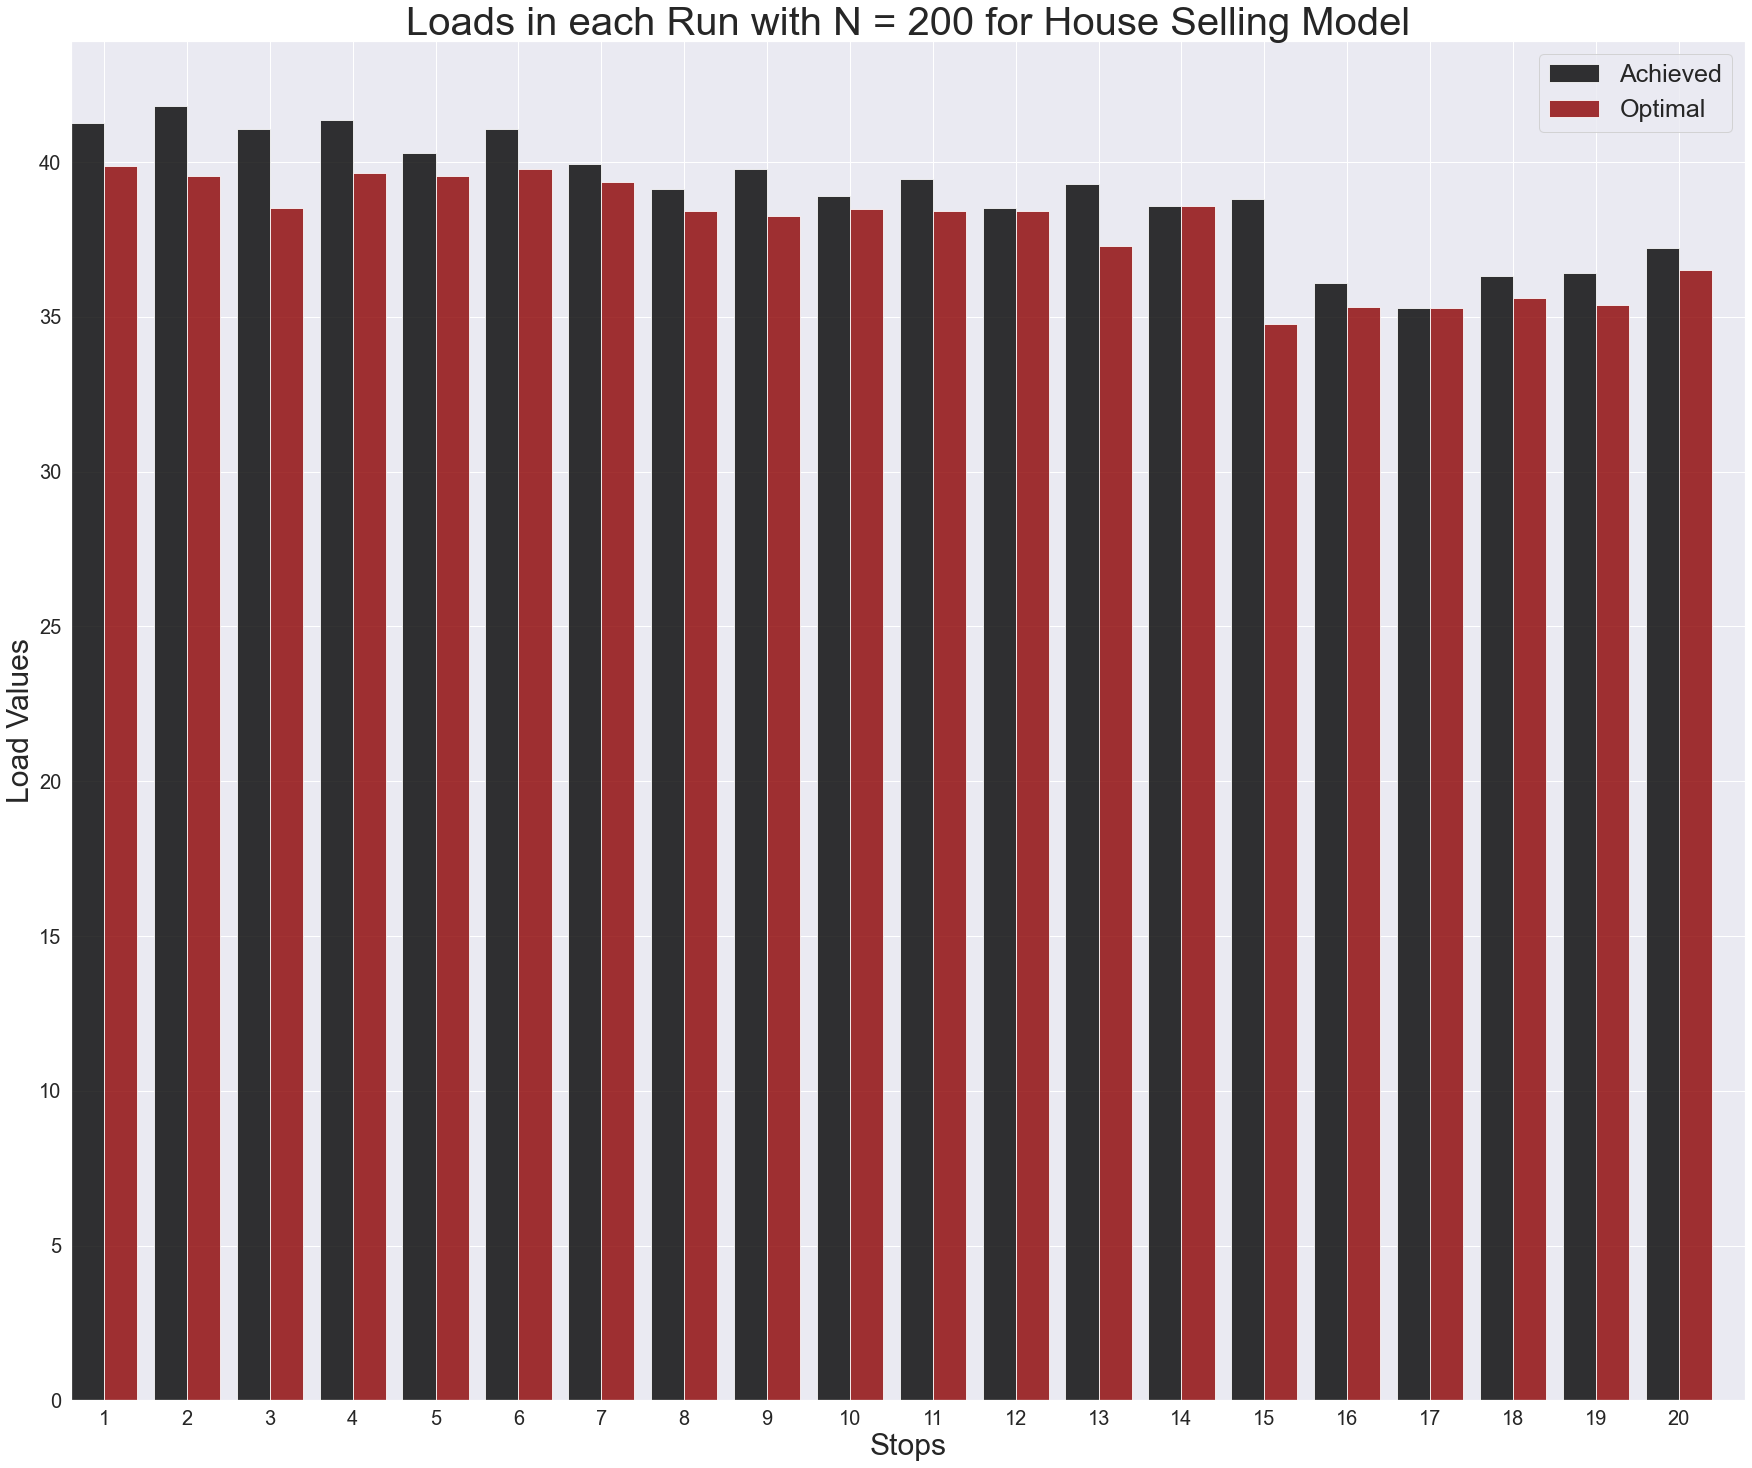

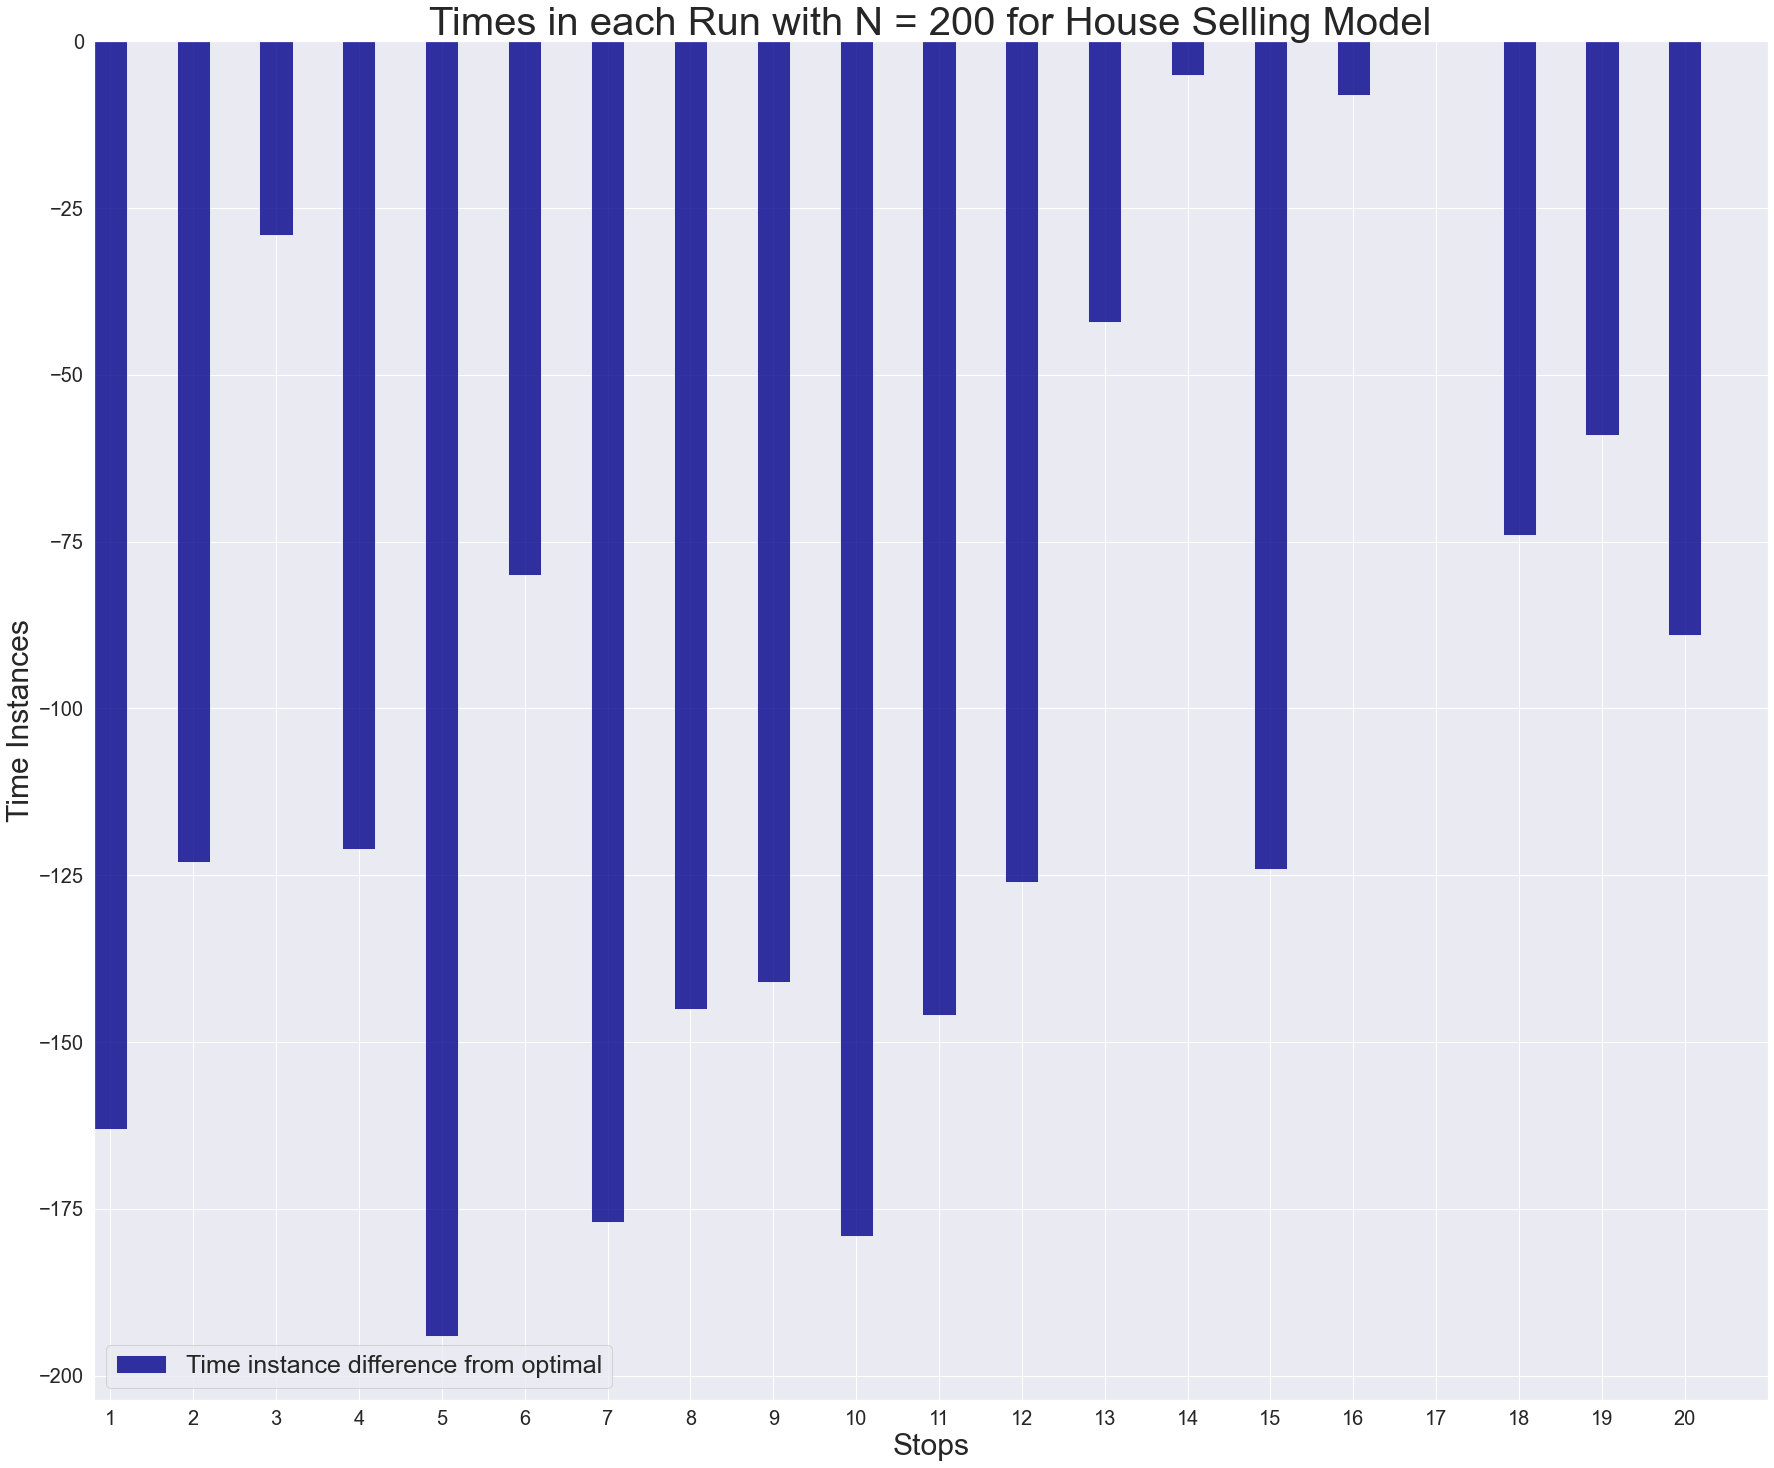

In [23]:
if __name__ == "__main__":
     main()